# Just Sanity Checks of dependencies for the tensorflow exam

Check Python version and TF version

In [2]:
import tensorflow as tf
import sys
print(tf.__version__)
print(sys.version)

2.12.0
3.9.6 (default, Mar 10 2023, 20:16:38) 
[Clang 14.0.3 (clang-1403.0.22.14.1)]


Check if we're using GPU to train

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# TF Exam Test

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Loading images from the disk

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 11s 0us/step


In [6]:
print(list(data_dir.glob('*/')))

[PosixPath('/Users/isaac/.keras/datasets/flower_photos/roses'), PosixPath('/Users/isaac/.keras/datasets/flower_photos/sunflowers'), PosixPath('/Users/isaac/.keras/datasets/flower_photos/daisy'), PosixPath('/Users/isaac/.keras/datasets/flower_photos/dandelion'), PosixPath('/Users/isaac/.keras/datasets/flower_photos/tulips'), PosixPath('/Users/isaac/.keras/datasets/flower_photos/LICENSE.txt')]


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))


NameError: name 'PIL' is not defined

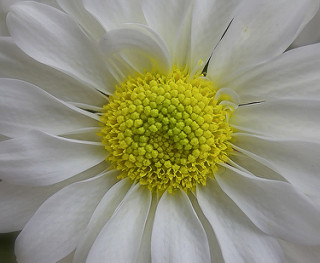

In [9]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

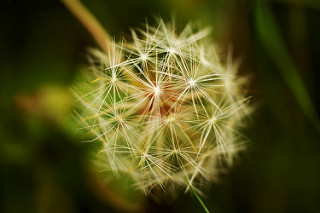

In [10]:
dandelion = list(data_dir.glob('dandelion/*'))
PIL.Image.open(str(dandelion[0]))

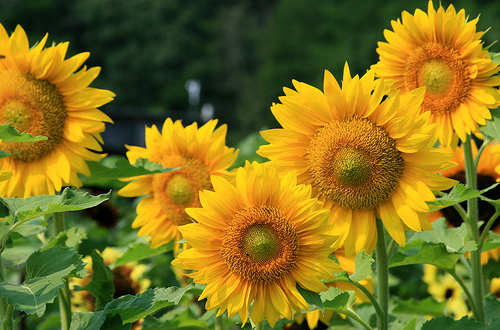

In [11]:
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

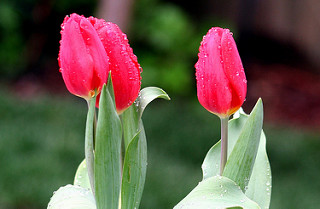

In [12]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## Loading images outside the disk using Keras utils

Creating a dataser

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [12]:
##Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Metal device set to: Apple M2 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [13]:
##Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [15]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Visualize data

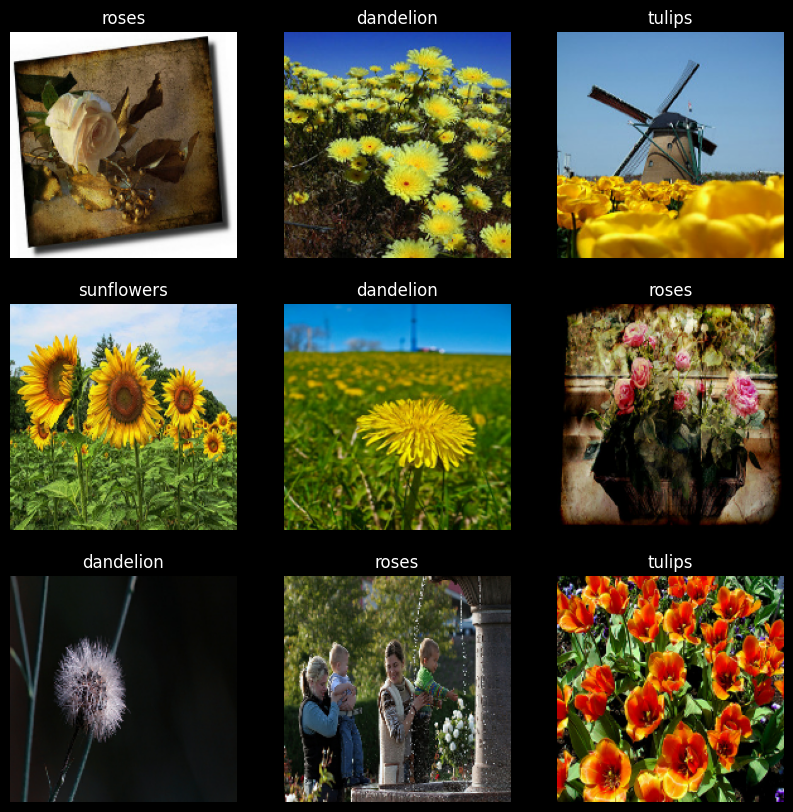

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Configure dataset for improve performance using cache and prefetch

* *Dataset.cache* keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* *Dataset.prefetch* overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standarize Data

In [19]:
from tensorflow.keras import layers

In [20]:
normalization_layer = layers.Rescaling(1./255)

We will use the layer inside the model definition later to simplify deployment but you caun use the rescaler using **map** method

In [21]:
'''
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''

'\nnormalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixel values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image))\n'

## Create the model

In [21]:
num_classes = len(class_names)

In [22]:
model = tf.keras.models.Sequential(
    [   ###Rescaling layer first
        tf.keras.layers.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
        ##Convolutions and Max poolings layers
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ]
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Compile Model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train Model

In [25]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-05-12 19:29:05.694490: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


92/92 [==============================] - 7s 41ms/step - loss: 1.3438 - accuracy: 0.4104 - val_loss: 1.0779 - val_accuracy: 0.5654
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 1.0141 - accuracy: 0.5937 - val_loss: 0.9534 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 3s 30ms/step - loss: 0.8156 - accuracy: 0.6884 - val_loss: 0.9543 - val_accuracy: 0.6308
Epoch 4/10
92/92 [==============================] - 3s 28ms/step - loss: 0.5992 - accuracy: 0.7786 - val_loss: 0.9517 - val_accuracy: 0.6540
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.3690 - accuracy: 0.8736 - val_loss: 1.1760 - val_accuracy: 0.6322
Epoch 6/10
92/92 [==============================] - 3s 29ms/step - loss: 0.2102 - accuracy: 0.9268 - val_loss: 1.2329 - val_accuracy: 0.6717
Epoch 7/10
92/92 [==============================] - 3s 29ms/step - loss: 0.1127 - accuracy: 0.9690 - val_loss: 1.3298 - val_accuracy: 0.6703
Epoch 8/10
92/92 [======

## Visualize Training Results

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [29]:
print(acc)
print(val_acc)

[0.47649863362312317, 0.6154631972312927, 0.6955040693283081, 0.7867847681045532, 0.8555858135223389, 0.919618546962738, 0.9655994772911072, 0.9782016277313232, 0.9809264540672302, 0.9856948256492615]
[0.528610348701477, 0.5844686627388, 0.611716628074646, 0.6457765698432922, 0.608991801738739, 0.6716621518135071, 0.6553133726119995, 0.6689373254776001, 0.6512261629104614, 0.6553133726119995]


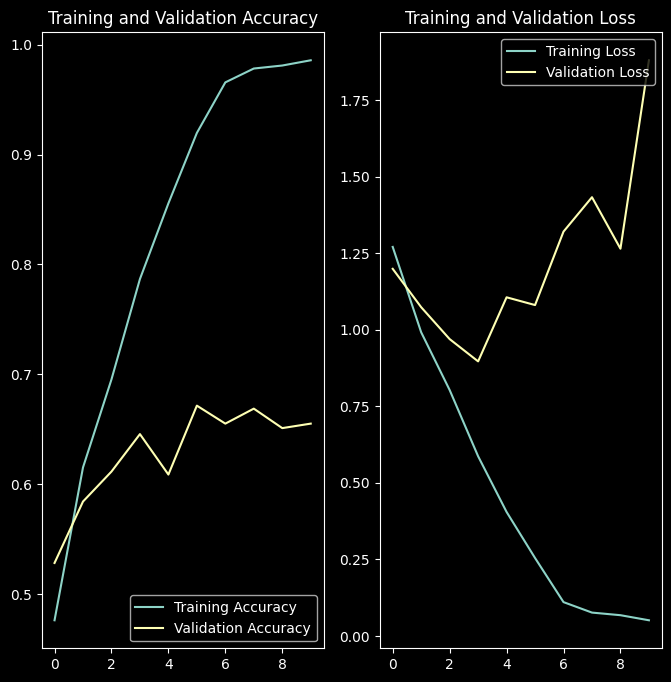

In [30]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observe we have a problem of overfitting

## Data Augmentation

We will implement data augmentation using the following Keras preprocessing layers: [tf.keras.layers.RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [tf.keras.layers.RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomRotation), and [tf.keras.layers.RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomZoom)

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [33]:
data_augmentation.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


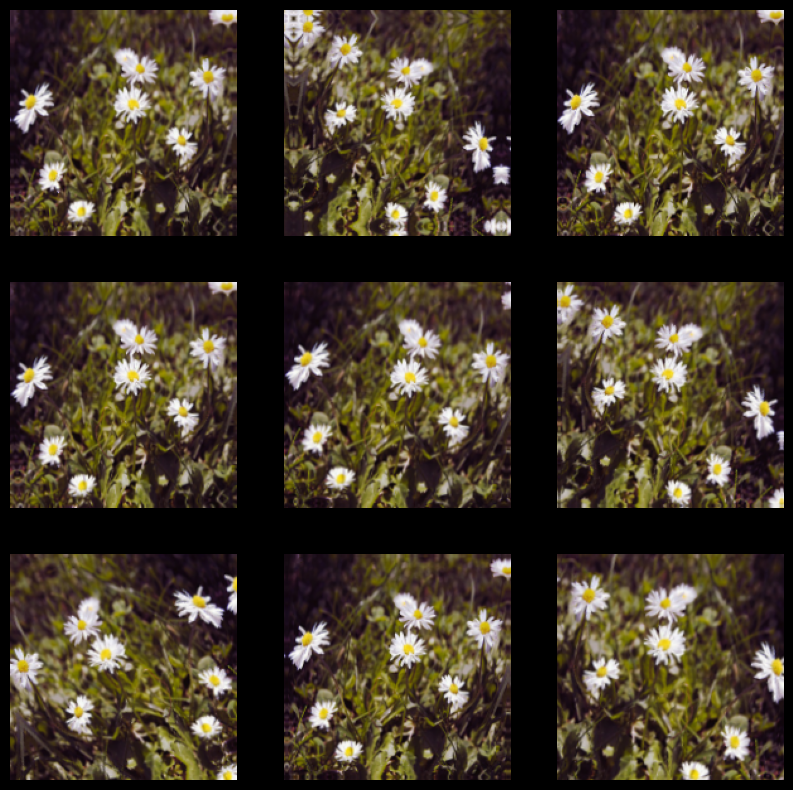

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Applying dropot before use data augmentation **Note we're adding the data augmentation before rescalling and dropout before the Flatten layer but we could add it wherever**

In [35]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 103ms/step - loss: 1.3715 - accuracy: 0.4077 - val_loss: 1.0996 - val_accuracy: 0.5763
Epoch 2/15
92/92 [==============================] - 9s 100ms/step - loss: 1.0487 - accuracy: 0.5841 - val_loss: 1.0299 - val_accuracy: 0.5790
Epoch 3/15
92/92 [==============================] - 9s 101ms/step - loss: 0.9537 - accuracy: 0.6226 - val_loss: 0.9612 - val_accuracy: 0.6240
Epoch 4/15
92/92 [==============================] - 9s 100ms/step - loss: 0.8939 - accuracy: 0.6574 - val_loss: 0.8778 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 9s 100ms/step - loss: 0.8356 - accuracy: 0.6775 - val_loss: 0.8608 - val_accuracy: 0.6594
Epoch 6/15
92/92 [==============================] - 9s 100ms/step - loss: 0.7907 - accuracy: 0.6921 - val_loss: 0.8309 - val_accuracy: 0.6553
Epoch 7/15
92/92 [==============================] - 10s 104ms/step - loss: 0.7548 - accuracy: 0.7098 - val_loss: 0.7721 - val_accuracy: 0.7030
Epoc

After applying data augmentation and [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), there is less overfitting than before, and training and validation accuracy are closer aligned:

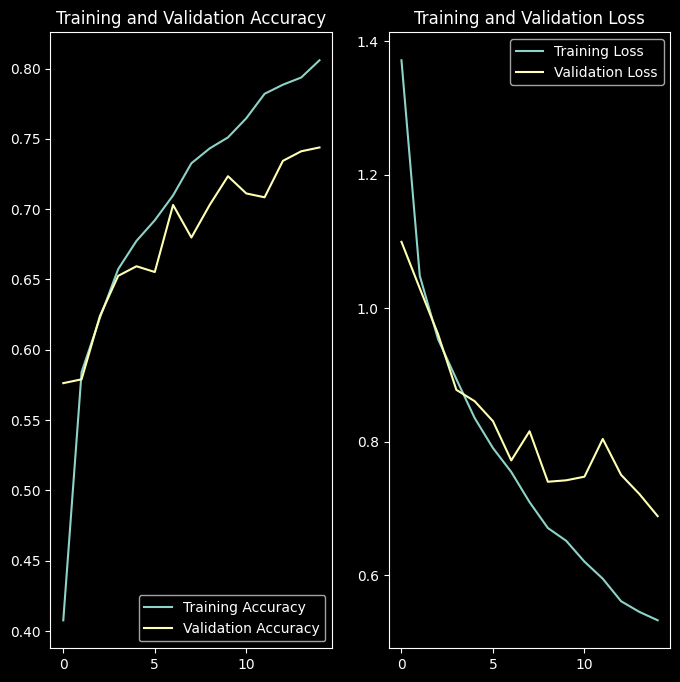

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

**Note: Data augmentation and dropout layers are inactive at inference time.**

In [41]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 473ms/step
This image most likely belongs to sunflowers with a 95.91 percent confidence.


In [46]:
rose_url = "https://cdn.shopify.com/s/files/1/0047/9730/0847/products/nurserylive-g-plants-rose-dark-pink-plant-in-grower-round-black-pot_600x600.jpg?"
rose_path = tf.keras.utils.get_file('nurserylive-g-plants-rose-dark-pink-plant-in-grower-round-black-pot_600x600', origin=rose_url)

img = tf.keras.utils.load_img(
    rose_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 14ms/step
This image most likely belongs to tulips with a 57.76 percent confidence.


In [48]:
rose_url = "https://www.classicroses.co.uk/media/catalog/product/cache/6e9e0330b981bee0eba0610998958c79/y/o/you_re_beautiful_bm_2019_2_1000px.jpg"
rose_path = tf.keras.utils.get_file('you_re_beautiful_bm_2019_2_1000px', origin=rose_url)

img = tf.keras.utils.load_img(
    rose_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 14ms/step
This image most likely belongs to roses with a 99.83 percent confidence.


## Save the Model

### Save Checkpoints of the model

Create a [tf.keras.callbacks.ModelCheckpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback that saves weights only during training:


In [85]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
model.fit(train_ds, 
          validation_data=val_ds,  
          epochs=10,
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.8123
Epoch 1: saving model to training_1\cp.ckpt
92/92 [==============================] - 10s 101ms/step - loss: 0.5015 - accuracy: 0.8123 - val_loss: 0.7811 - val_accuracy: 0.7193
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8249
Epoch 2: saving model to training_1\cp.ckpt
92/92 [==============================] - 9s 101ms/step - loss: 0.4741 - accuracy: 0.8249 - val_loss: 0.6820 - val_accuracy: 0.7670
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.4477 - accuracy: 0.8345
Epoch 3: saving model to training_1\cp.ckpt
92/92 [==============================] - 10s 104ms/step - loss: 0.4477 - accuracy: 0.8345 - val_loss: 0.7592 - val_accuracy: 0.7534
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.4550 - accuracy: 0.8300
Epoch 4: saving model to training_1\cp.ckpt
92/92 [==============================] - 10s 107ms/st

In [86]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

### Save the entire model

Call [tf.keras.Model.save](https://www.tensorflow.org/api_docs/python/tf/keras/Model#save) to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

In [87]:
# Train the model with the new callback
model.fit(train_ds, 
          validation_data=val_ds,  
          epochs=5) 
model.save('saved_model/my_model')

Epoch 1/5
92/92 [==============================] - 9s 98ms/step - loss: 0.3256 - accuracy: 0.8804 - val_loss: 0.7176 - val_accuracy: 0.7807
Epoch 2/5
92/92 [==============================] - 9s 100ms/step - loss: 0.3254 - accuracy: 0.8811 - val_loss: 0.8157 - val_accuracy: 0.7452
Epoch 3/5
92/92 [==============================] - 9s 102ms/step - loss: 0.3067 - accuracy: 0.8862 - val_loss: 0.7302 - val_accuracy: 0.7684
Epoch 4/5
92/92 [==============================] - 10s 105ms/step - loss: 0.2899 - accuracy: 0.8954 - val_loss: 0.6979 - val_accuracy: 0.7657
Epoch 5/5
92/92 [==============================] - 9s 102ms/step - loss: 0.2814 - accuracy: 0.9012 - val_loss: 0.7137 - val_accuracy: 0.7820


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [88]:
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [89]:
model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')

Epoch 1/5
92/92 [==============================] - 9s 101ms/step - loss: 0.2631 - accuracy: 0.9084 - val_loss: 0.7508 - val_accuracy: 0.7698
Epoch 2/5
92/92 [==============================] - 10s 103ms/step - loss: 0.2718 - accuracy: 0.9111 - val_loss: 0.8517 - val_accuracy: 0.7398
Epoch 3/5
92/92 [==============================] - 10s 107ms/step - loss: 0.2660 - accuracy: 0.9022 - val_loss: 0.7543 - val_accuracy: 0.7725
Epoch 4/5
92/92 [==============================] - 10s 104ms/step - loss: 0.2278 - accuracy: 0.9237 - val_loss: 0.8575 - val_accuracy: 0.7711
Epoch 5/5
92/92 [==============================] - 10s 104ms/step - loss: 0.2201 - accuracy: 0.9240 - val_loss: 0.8722 - val_accuracy: 0.7670


In [90]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Use Tensorflow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.



## Convert the Keras Sequential model to a TensorFlow Lite model

In [49]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\param\AppData\Local\Temp\tmpbjxahs1u\assets


INFO:tensorflow:Assets written to: C:\Users\param\AppData\Local\Temp\tmpbjxahs1u\assets


## Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the [tf.lite.Interpreter](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) class.

In [50]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [51]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [52]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [53]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [54]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to roses with a 99.83 percent confidence.
